## Exercise 2: Fixed Adjustment Cost

In [38]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time

# to print plots inline
%matplotlib inline

In [39]:
# Specify parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
c = 0.3
w = 0.7
r = 0.04
sigma_eps = 0.213
mu = 0.0
rho = 0.7605
sizez = 9

betafirm = (1 / (1 + r))

In [40]:
# Use Adda-Cooper(2003) method to set up the endpoints for the z values

# import packages
from scipy.stats import norm

# Compute cut-off values
N = 9  # number of grid points (will have one more cut-off point than this)
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
z_grid_init = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
print('Grid points = ', z_grid_init)

Grid points =  [-0.55913938 -0.32004072 -0.19425291 -0.09290094  0.          0.09290094
  0.19425291  0.32004072  0.55913938]


In [41]:
import math

"""This section of the code establishes an initial grid which will be a NumPy array
in this case of size 7x57x2."""

# Set up density grid for k and z
dens = 1
# put in bounds here for the capital stock space
grid = []

kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) ** (alpha_l / (1 - alpha_l)))) / (alpha_k * (1 ** (1 / (1 - alpha_l))))) **((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

grid_star = []
lnz_grid = z_grid_init
z_grid = np.exp(z_grid_init)
for i in range(len(z_grid)):
    for j in range(sizek):
        grid_star.append(np.array([z_grid[i],kvec[j]]))
grid = np.array(grid_star)
grid = grid.reshape(N, sizek, 2)
m,n,o = np.shape(grid)

In [42]:
# Operating Profits, op
op = np.zeros((n,m))
for i in range(m):
    for j in range(n):
        op[j,i] = (((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) \
                    * ((grid[i,j,0])**(1/(1-alpha_l))) * \
                    ((grid[i,j,1])**(alpha_k/(1-alpha_l)))))

# Firm cash flow, e
e = np.zeros((n,n,m))
for i in range(n):
    for j in range(n):
        for k in range(m):
            e[i, j, k] = op[i,k] - grid[k,j,1] + ((1 - delta) * grid[k,i,1]) - c*(grid[k,i,1])

In [43]:
# Initialization of Value Function Iteration
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((n,m))  # initial guess at value function
Vmat = np.zeros((n,n,m))  # initialize Vmat matrix
Vstore = np.zeros((n,m,VFmaxiter))  # initialize Vstore array
VFiter = 1
start_time = time.clock()

In [44]:
# Determine the transition matrix pi between each z

# import packages
import scipy.integrate as integrate

# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]
        
print('Transition matrix = ', pi)

Transition matrix =  [[  5.34646999e-01   2.33099908e-01   1.19241334e-01   6.16948412e-02
    3.06368282e-02   1.38694209e-02   5.27307457e-03   1.39972319e-03
    1.37871226e-04]
 [  2.33099908e-01   2.53066831e-01   1.95990939e-01   1.38221479e-01
    8.98690322e-02   5.26608516e-02   2.62024217e-02   9.48881413e-03
    1.39972319e-03]
 [  1.19241334e-01   1.95990939e-01   1.96744233e-01   1.70765394e-01
    1.33994761e-01   9.44950201e-02   5.72928238e-02   2.62024217e-02
    5.27307457e-03]
 [  6.16948412e-02   1.38221479e-01   1.70765394e-01   1.75481409e-01
    1.60693238e-01   1.32118347e-01   9.44950201e-02   5.26608516e-02
    1.38694209e-02]
 [  3.06368282e-02   8.98690322e-02   1.33994761e-01   1.60693238e-01
    1.69612281e-01   1.60693238e-01   1.33994761e-01   8.98690322e-02
    3.06368282e-02]
 [  1.38694209e-02   5.26608516e-02   9.44950201e-02   1.32118347e-01
    1.60693238e-01   1.75481409e-01   1.70765394e-01   1.38221479e-01
    6.16948412e-02]
 [  5.27307457e-03 

In [48]:
# Loop procedure with discrete transition probabilities added
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V
    for i in range(n):  # loop over z
        for j in range(n):  # loop over k'
            for k in range(m): #loop over k, this line would need to be changed for the size of m
                if i==0:
                    Vmat[i, j, k] = max(e[i, j, k] + betafirm * (V[j,0] * pi[0,k] + V[j,1] * pi[1,k] + \
                                                             V[j,2] * pi[2,k] + V[j,3] * pi[3,k] + \
                                                             V[j,4] * pi[4,k] + V[j,5] * pi[5,k] + \
                                                             V[j,6] * pi[6,k] + V[j,7] * pi[7,k] + \
                                                             V[j,8] * pi[8,k]), 
                                        op[i, k] + betafirm * (V[i,0] * pi[0,k] + V[i,1] * pi[1,k] + \
                                                             V[i,2] * pi[2,k] + V[i,3] * pi[3,k] + \
                                                             V[i,4] * pi[4,k] + V[i,5] * pi[5,k] + \
                                                             V[i,6] * pi[6,k] + V[i,7] * pi[7,k] + \
                                                             V[i,8] * pi[8,k]))
                else:
                    Vmat[i, j, k] = max(e[i, j, k] + betafirm * (V[j,0] * pi[0,k] + V[j,1] * pi[1,k] + \
                                                             V[j,2] * pi[2,k] + V[j,3] * pi[3,k] + \
                                                             V[j,4] * pi[4,k] + V[j,5] * pi[5,k] + \
                                                             V[j,6] * pi[6,k] + V[j,7] * pi[7,k] + \
                                                             V[j,8] * pi[8,k]), 
                                        op[i, k] + betafirm * (V[i-1,0] * pi[0,k] + V[i-1,1] * pi[1,k] + \
                                                             V[i-1,2] * pi[2,k] + V[i-1,3] * pi[3,k] + \
                                                             V[i-1,4] * pi[4,k] + V[i-1,5] * pi[5,k] + \
                                                             V[i-1,6] * pi[6,k] + V[i-1,7] * pi[7,k] + \
                                                             V[i-1,8] * pi[8,k]))
    Vstore[:,:, VFiter] = V.reshape(n,m)  # store value function at each
    # iteration for graphing later
    V = Vmat.max(axis=1)  # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')

VF = V  # solution to the functional equation

Value function converged after this many iterations: 363
VFI took  147.16170899999997  seconds to solve


In [49]:
optK = np.zeros((n,m))
optI = np.zeros((n,m))
for i in range(n):
    for j in range(m):
        optK[i,j] = grid[j,PF[i,j],1]
        optI[i,j] = optK[i,j] - (1-delta)*grid[j,PF[i,j],1]
print(optK)

[[  1.15944493e-03   1.15944493e-03   2.89086723e-01   4.77438082e-01
    6.67077559e-01   1.35366062e+01   1.35366062e+01   1.35366062e+01
    1.35366062e+01]
 [  1.15944493e-03   1.15944493e-03   2.89086723e-01   4.77438082e-01
    6.67077559e-01   1.35366062e+01   1.35366062e+01   1.35366062e+01
    1.35366062e+01]
 [  1.15944493e-03   1.15944493e-03   2.89086723e-01   4.77438082e-01
    6.67077559e-01   1.35366062e+01   1.35366062e+01   1.35366062e+01
    1.35366062e+01]
 [  1.15944493e-03   1.15944493e-03   2.89086723e-01   4.77438082e-01
    6.67077559e-01   1.35366062e+01   1.35366062e+01   1.35366062e+01
    1.35366062e+01]
 [  1.15944493e-03   1.15944493e-03   2.89086723e-01   4.77438082e-01
    6.67077559e-01   1.35366062e+01   1.35366062e+01   1.35366062e+01
    1.35366062e+01]
 [  1.15944493e-03   1.15944493e-03   2.89086723e-01   4.77438082e-01
    6.67077559e-01   1.35366062e+01   1.35366062e+01   1.35366062e+01
    1.35366062e+01]
 [  1.15944493e-03   1.15944493e-03   2.

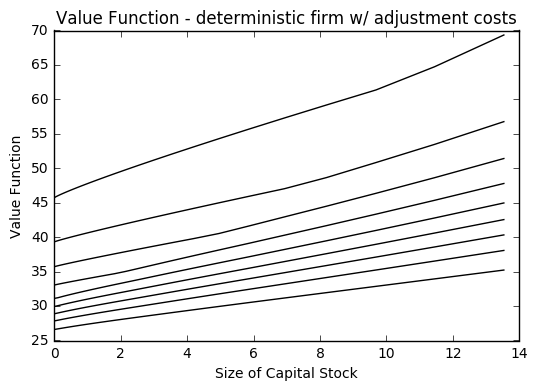

In [50]:
# Plot value function
for i in range(m):
    plt.plot(grid[i,:,1], VF[:,i], 'k')
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic firm w/ adjustment costs')

/Users/Geoff/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


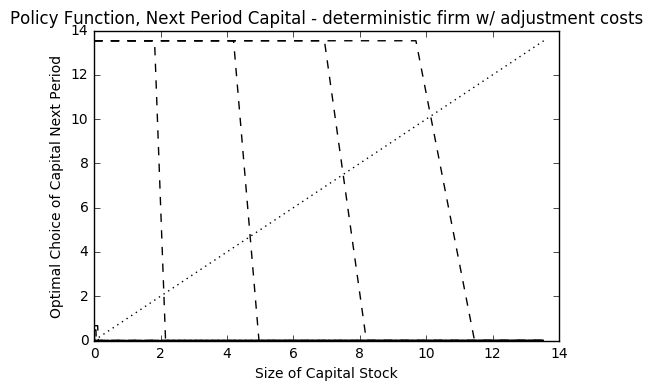

In [51]:
# Plot Capital Policy Function

kvec = grid[0,:,1]
fig, ax = plt.subplots()
for i in range(m):
    ax.plot(kvec, optK[:,i], 'k--')
ax.plot(kvec, kvec, 'k:')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=True)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capital - deterministic firm w/ ' +
          'adjustment costs')

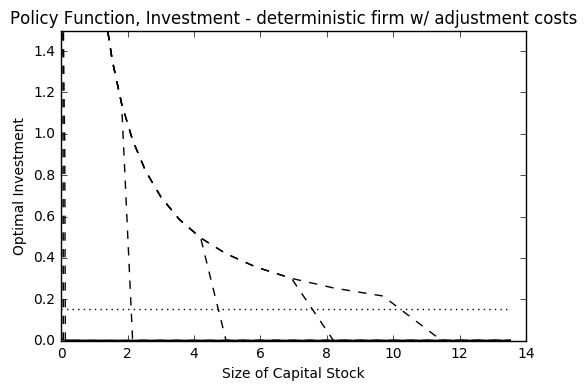

In [52]:
# Plot Investment Policy Function as function of firm size

fig, ax = plt.subplots()
for i in range(m):
    ax.plot(kvec, (optI[:,i]/kvec), 'k--')
ax.plot(kvec, (np.ones(sizek)*delta), 'k:')
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Investment')
plt.axis([0,14,0,1.5])
plt.title('Policy Function, Investment - deterministic firm w/ adjustment ' +
          'costs')
